# <font color='blue'>Belgian Traffic Sign Detection</font>

This dataset contains several images of traffic sign, and the objective of this notebook is to implement an algorithm able to correctly classify traffic signs.

The dataset can be found at http://btsd.ethz.ch/shareddata/. Two files will be used: 
- BelgiumTSC_Training (171.3MBytes)
- BelgiumTSC_Testing (76.5MBytes)

In order to solve this problem I created a CNN using Keras. There wasn't much pre-processing on the dataset as my objective here was to practice building CNN models using the mentioned framework.

In [1]:
# Import packages
import os
import random
import skimage.data
import skimage.transform
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from myutils2 import *
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

/home/daragaki/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# Define the path where the data is and load them into lists

path = "/home/daragaki/DeepLearningI/Cap07/"

train_directory = os.path.join(path, "BelgiumTS/Training")
test_directory = os.path.join(path, "BelgiumTS/Testing")

train_image, train_label = load_data(train_directory)
test_image, test_label = load_data(test_directory)

print('Train dataset: {} images and {} labels.'.format(len(train_image), len(set(train_label))))
print('Test dataset:  {} images and {} labels.'.format(len(test_image), len(set(test_label))))

Train dataset: 4575 images and 62 labels.
Test dataset:  2520 images and 53 labels.


Let's look at some of these images. Below we're able to see what each label represents.

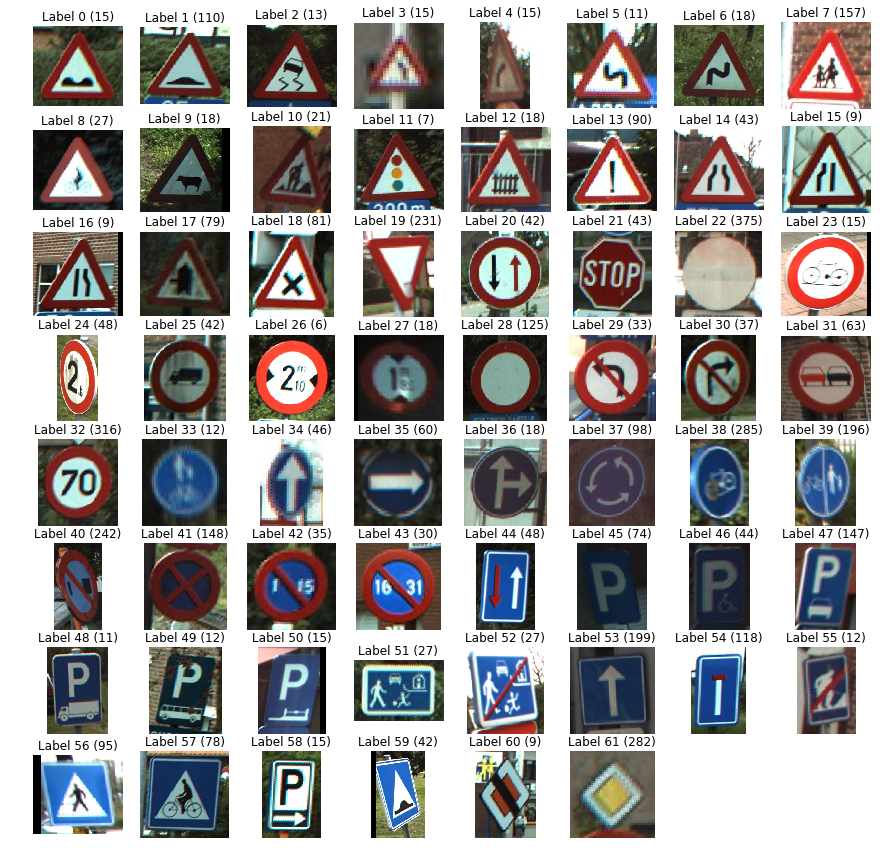

In [3]:
# Display one image of each label
display_images_and_labels(train_image, train_label)

As you can see, each label represents a different traffic sign. If we inspect a particular label, we can get a better idea of the characteristics of each traffic sign. Let's try labels 32 and 36!

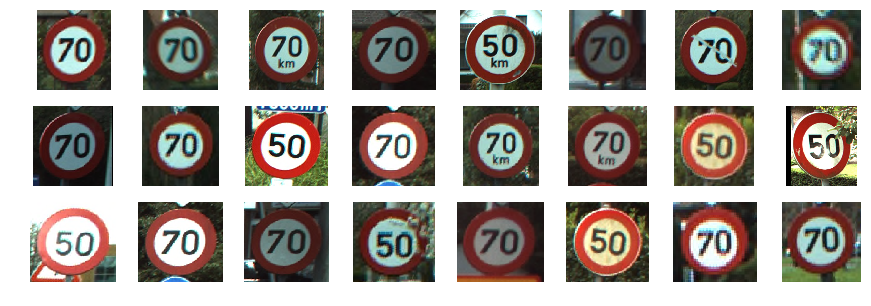

In [4]:
# Display a few images from a chosen label
display_images(train_image, train_label, 32)

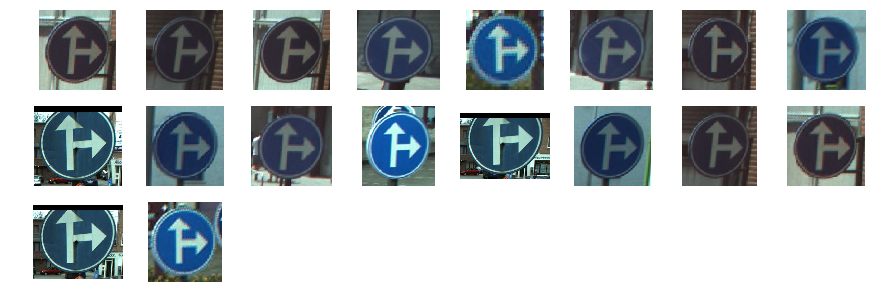

In [5]:
# Display a few images from a chosen label
display_images(train_image, train_label, 36)

Ok, so depending on the traffic sign, there might be or not a few differences in the content. For the label 36, they all seem to be pretty much the same, however when we look at label 32, the format is the same but the number inside might change, and we see as well that the traffic sign sometimes displays 'km'. Let's see if our model will be able to catch such nuances!

What other characteristics are present in our dataset? Well, by just looking at it, we can already infer that we have coloured images, mostly with a squared size. We also notice images where they were taken in diverse lighting condition
and/ or from different angles.

But let's move on and check image sizes:

In [6]:
# Check image sizes
print('Train dataset:')
for image in train_image[:5]:
    print("Shape: {}, min: {}, max: {}".format(image.shape, image.min(), image.max()))
    
print('\nTest dataset:')
for image in test_image[:5]:
    print("Shape: {}, min: {}, max: {}".format(image.shape, image.min(), image.max()))

Train dataset:
Shape: (134, 109, 3), min: 19, max: 255
Shape: (43, 35, 3), min: 7, max: 255
Shape: (88, 93, 3), min: 29, max: 155
Shape: (131, 153, 3), min: 16, max: 255
Shape: (81, 95, 3), min: 20, max: 255

Test dataset:
Shape: (60, 64, 3), min: 0, max: 255
Shape: (43, 45, 3), min: 17, max: 255
Shape: (76, 86, 3), min: 24, max: 226
Shape: (193, 237, 3), min: 0, max: 255
Shape: (134, 158, 3), min: 11, max: 236


So, now we can see the image's dimension and that width and height are close to each other. Besides that, the images are in RGB. So, what should I do prior to creating our model?

For now I'll only resize all images to (64, 64). We can perform data augmentation but I'll leave it for another occasion. The decision to utilize (64,64) came from both looking at the images and running the models with other sizes ((32,32), (64,64) and (128,128)). With the first you can run it fast but will lose details due to image quality, which will have a cost in accuracy. With (64,64) and (128,128), both presented close accuracy values, but of course it took the latter one longer to train. So I ended up with the value below..

In [7]:
# Resize images to 64 x 64
size = 64

train_resized = [skimage.transform.resize(image, (size, size)) for image in train_image]
test_resized  = [skimage.transform.resize(image, (size, size)) for image in test_image]

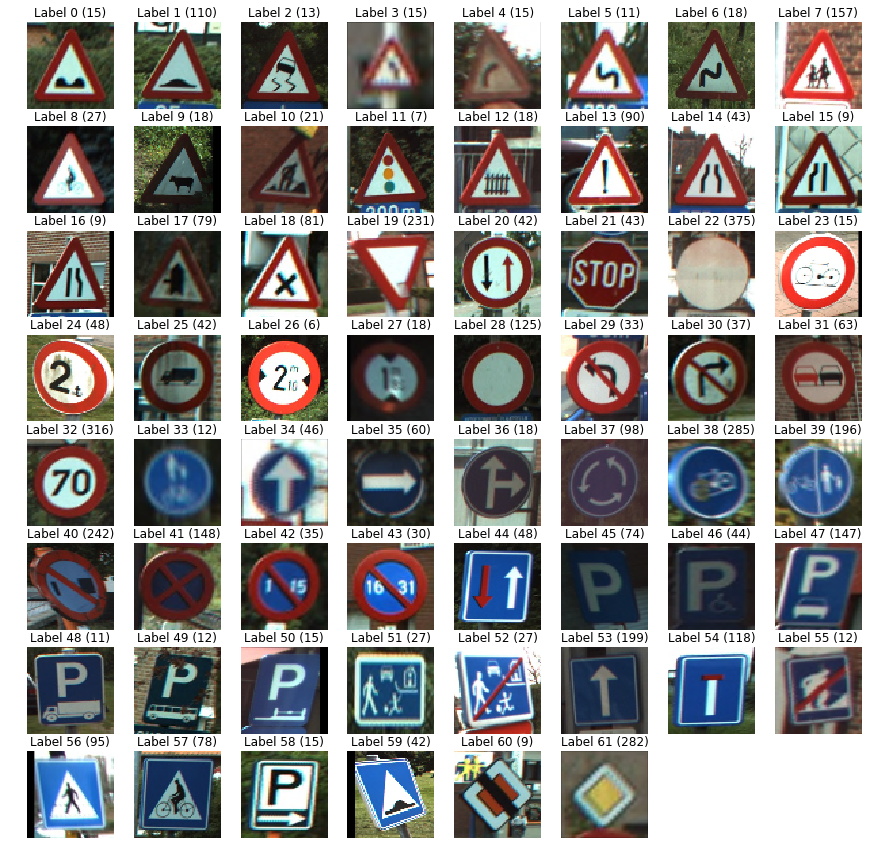

In [8]:
# Display train resized images
display_images_and_labels(train_resized, train_label)

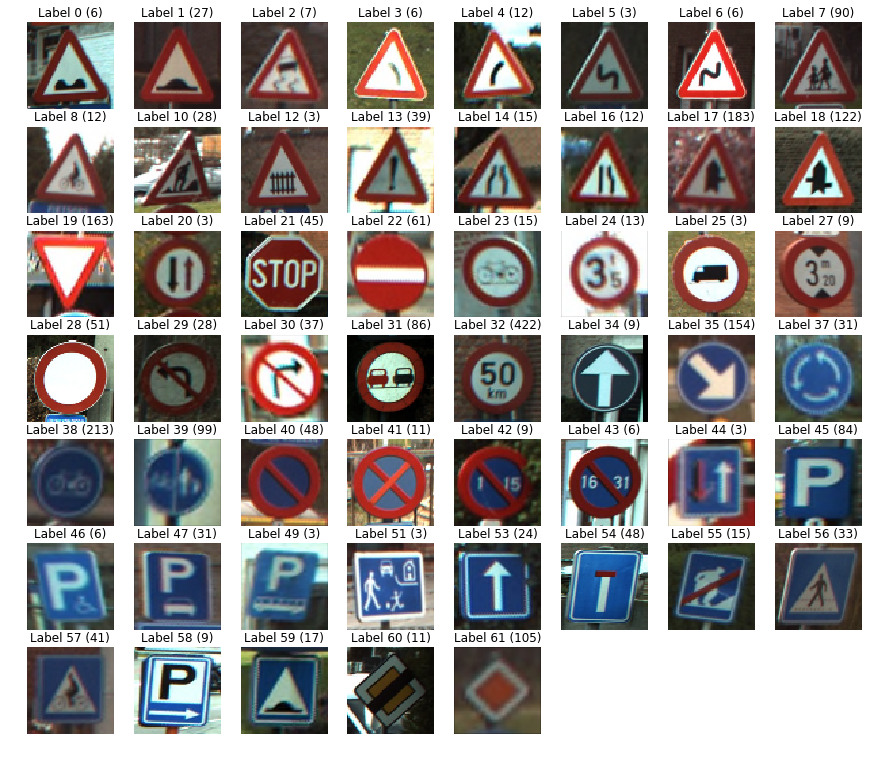

In [9]:
# Display test resized images
display_images_and_labels(test_resized, test_label)

In [10]:
# Checking resized dimensions
print('Train dataset:')
for image in train_resized[:2]:
    print("Shape: {}, min: {}, max: {}".format(image.shape, image.min(), image.max()))
    
print('\nTest dataset:')
for image in test_resized[:2]:
    print("Shape: {}, min: {}, max: {}".format(image.shape, image.min(), image.max()))

Train dataset:
Shape: (64, 64, 3), min: 0.08247405407475511, max: 1.0
Shape: (64, 64, 3), min: 0.0671666762408089, max: 1.0

Test dataset:
Shape: (64, 64, 3), min: 0.006004901960784679, max: 1.0
Shape: (64, 64, 3), min: 0.08979755476409383, max: 1.0


So we are pretty much ready to build our model, given we won't perform data augmentation or make any other changes.

In this classification problem, we have 62 possible labels. To execute it using Keras, we need to to be in categorical format, i.e., one-hot encoded. Also, the input data should be an array.

In [11]:
from keras.utils import to_categorical

num_classes = 62

# Transform into array
X_train = np.array(train_resized)
y_train = np.array(train_label)
input_shape = X_train[1].shape

# Transform into array
X_test = np.array(test_resized)
y_test = np.array(test_label)

# Convert labels into categorical features (one-hot encode)
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

print('Train: images = {} and labels = {}'.format(X_train.shape, y_train.shape))
print('Test:  images = {} and labels = {}'.format(X_test.shape, y_test.shape))

Using TensorFlow backend.


Train: images = (4575, 64, 64, 3) and labels = (4575, 62)
Test:  images = (2520, 64, 64, 3) and labels = (2520, 62)


In [12]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential()
model.add(Conv2D(filters = 8, kernel_size = 2, padding = 'same', activation = 'relu', input_shape = input_shape))
model.add(MaxPooling2D(pool_size = 2))
model.add(Conv2D(filters = 32, kernel_size = 2, padding = 'same', activation = 'relu'))
model.add(MaxPooling2D(pool_size = 2))
model.add(Conv2D(filters = 3, kernel_size = 2, padding = 'same', activation = 'relu'))
model.add(MaxPooling2D(pool_size = 2))
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(200, activation = 'relu'))
model.add(Dropout(0.4))
model.add(Dense(62, activation = 'softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 64, 64, 8)         104       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 8)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        1056      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 3)         387       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 8, 8, 3)           0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 8, 8, 3)           0         
__________

In [13]:
model.compile(loss = 'categorical_crossentropy', optimizer = 'rmsprop', metrics = ['accuracy'])

In [14]:
from keras.callbacks import ModelCheckpoint   
from keras_tqdm import TQDMNotebookCallback

batch_size = 100
epochs = 100

# Saving best model (weights)
checkpoint = ModelCheckpoint(filepath = 'belgian_traffic_sign.weights.best.hdf5', verbose = 1, save_best_only = True)

model.fit(X_train, y_train, 
          validation_data = (X_test, y_test), 
          epochs = epochs, 
          batch_size = batch_size, 
          callbacks = [checkpoint, TQDMNotebookCallback()], 
          verbose = 0, 
          shuffle = True)


Epoch 00001: val_loss improved from inf to 3.01075, saving model to belgian_traffic_sign.weights.best.hdf5



Epoch 00002: val_loss improved from 3.01075 to 2.27076, saving model to belgian_traffic_sign.weights.best.hdf5



Epoch 00003: val_loss improved from 2.27076 to 1.90638, saving model to belgian_traffic_sign.weights.best.hdf5



Epoch 00004: val_loss improved from 1.90638 to 1.68291, saving model to belgian_traffic_sign.weights.best.hdf5



Epoch 00005: val_loss improved from 1.68291 to 1.43177, saving model to belgian_traffic_sign.weights.best.hdf5



Epoch 00006: val_loss improved from 1.43177 to 1.37821, saving model to belgian_traffic_sign.weights.best.hdf5



Epoch 00007: val_loss improved from 1.37821 to 1.12264, saving model to belgian_traffic_sign.weights.best.hdf5



Epoch 00008: val_loss improved from 1.12264 to 1.08761, saving model to belgian_traffic_sign.weights.best.hdf5



Epoch 00009: val_loss improved from 1.08761 to 0.92513, saving model to belgian_traffic_sign.weights.best.hdf5



Epoch 00010: val_loss improved from 0.92513 to 0.89166, saving model to belgian_traffic_sign.weights.best.hdf5



Epoch 00011: val_loss improved from 0.89166 to 0.76290, saving model to belgian_traffic_sign.weights.best.hdf5



Epoch 00012: val_loss improved from 0.76290 to 0.72217, saving model to belgian_traffic_sign.weights.best.hdf5



Epoch 00013: val_loss improved from 0.72217 to 0.65876, saving model to belgian_traffic_sign.weights.best.hdf5



Epoch 00014: val_loss improved from 0.65876 to 0.62198, saving model to belgian_traffic_sign.weights.best.hdf5



Epoch 00015: val_loss improved from 0.62198 to 0.58056, saving model to belgian_traffic_sign.weights.best.hdf5



Epoch 00016: val_loss improved from 0.58056 to 0.54813, saving model to belgian_traffic_sign.weights.best.hdf5



Epoch 00017: val_loss improved from 0.54813 to 0.52781, saving model to belgian_traffic_sign.weights.best.hdf5



Epoch 00018: val_loss did not improve from 0.52781



Epoch 00019: val_loss improved from 0.52781 to 0.47993, saving model to belgian_traffic_sign.weights.best.hdf5



Epoch 00020: val_loss improved from 0.47993 to 0.46872, saving model to belgian_traffic_sign.weights.best.hdf5



Epoch 00021: val_loss improved from 0.46872 to 0.44175, saving model to belgian_traffic_sign.weights.best.hdf5



Epoch 00022: val_loss improved from 0.44175 to 0.41634, saving model to belgian_traffic_sign.weights.best.hdf5



Epoch 00023: val_loss did not improve from 0.41634



Epoch 00024: val_loss did not improve from 0.41634



Epoch 00025: val_loss improved from 0.41634 to 0.39721, saving model to belgian_traffic_sign.weights.best.hdf5



Epoch 00026: val_loss improved from 0.39721 to 0.39644, saving model to belgian_traffic_sign.weights.best.hdf5



Epoch 00027: val_loss did not improve from 0.39644



Epoch 00028: val_loss improved from 0.39644 to 0.39179, saving model to belgian_traffic_sign.weights.best.hdf5



Epoch 00029: val_loss improved from 0.39179 to 0.35684, saving model to belgian_traffic_sign.weights.best.hdf5



Epoch 00030: val_loss did not improve from 0.35684



Epoch 00031: val_loss did not improve from 0.35684



Epoch 00032: val_loss improved from 0.35684 to 0.34367, saving model to belgian_traffic_sign.weights.best.hdf5



Epoch 00033: val_loss did not improve from 0.34367



Epoch 00034: val_loss improved from 0.34367 to 0.33270, saving model to belgian_traffic_sign.weights.best.hdf5



Epoch 00035: val_loss improved from 0.33270 to 0.33200, saving model to belgian_traffic_sign.weights.best.hdf5



Epoch 00036: val_loss did not improve from 0.33200



Epoch 00037: val_loss did not improve from 0.33200



Epoch 00038: val_loss did not improve from 0.33200



Epoch 00039: val_loss improved from 0.33200 to 0.31886, saving model to belgian_traffic_sign.weights.best.hdf5



Epoch 00040: val_loss improved from 0.31886 to 0.30181, saving model to belgian_traffic_sign.weights.best.hdf5



Epoch 00041: val_loss did not improve from 0.30181



Epoch 00042: val_loss did not improve from 0.30181



Epoch 00043: val_loss did not improve from 0.30181



Epoch 00044: val_loss did not improve from 0.30181



Epoch 00045: val_loss did not improve from 0.30181



Epoch 00046: val_loss did not improve from 0.30181



Epoch 00047: val_loss did not improve from 0.30181



Epoch 00048: val_loss improved from 0.30181 to 0.29698, saving model to belgian_traffic_sign.weights.best.hdf5



Epoch 00049: val_loss did not improve from 0.29698



Epoch 00050: val_loss did not improve from 0.29698



Epoch 00051: val_loss did not improve from 0.29698



Epoch 00052: val_loss improved from 0.29698 to 0.29314, saving model to belgian_traffic_sign.weights.best.hdf5



Epoch 00053: val_loss did not improve from 0.29314



Epoch 00054: val_loss did not improve from 0.29314



Epoch 00055: val_loss did not improve from 0.29314



Epoch 00056: val_loss did not improve from 0.29314



Epoch 00057: val_loss did not improve from 0.29314



Epoch 00058: val_loss improved from 0.29314 to 0.28417, saving model to belgian_traffic_sign.weights.best.hdf5



Epoch 00059: val_loss did not improve from 0.28417



Epoch 00060: val_loss did not improve from 0.28417



Epoch 00061: val_loss did not improve from 0.28417



Epoch 00062: val_loss did not improve from 0.28417



Epoch 00063: val_loss improved from 0.28417 to 0.27707, saving model to belgian_traffic_sign.weights.best.hdf5



Epoch 00064: val_loss did not improve from 0.27707



Epoch 00065: val_loss did not improve from 0.27707



Epoch 00066: val_loss did not improve from 0.27707



Epoch 00067: val_loss did not improve from 0.27707



Epoch 00068: val_loss did not improve from 0.27707



Epoch 00069: val_loss did not improve from 0.27707



Epoch 00070: val_loss did not improve from 0.27707



Epoch 00071: val_loss did not improve from 0.27707



Epoch 00072: val_loss did not improve from 0.27707



Epoch 00073: val_loss did not improve from 0.27707



Epoch 00074: val_loss did not improve from 0.27707



Epoch 00075: val_loss did not improve from 0.27707



Epoch 00076: val_loss did not improve from 0.27707



Epoch 00077: val_loss did not improve from 0.27707



Epoch 00078: val_loss did not improve from 0.27707



Epoch 00079: val_loss did not improve from 0.27707



Epoch 00080: val_loss did not improve from 0.27707



Epoch 00081: val_loss did not improve from 0.27707



Epoch 00082: val_loss did not improve from 0.27707



Epoch 00083: val_loss did not improve from 0.27707



Epoch 00084: val_loss improved from 0.27707 to 0.27057, saving model to belgian_traffic_sign.weights.best.hdf5



Epoch 00085: val_loss did not improve from 0.27057



Epoch 00086: val_loss did not improve from 0.27057



Epoch 00087: val_loss did not improve from 0.27057



Epoch 00088: val_loss did not improve from 0.27057



Epoch 00089: val_loss did not improve from 0.27057



Epoch 00090: val_loss did not improve from 0.27057



Epoch 00091: val_loss did not improve from 0.27057



Epoch 00092: val_loss did not improve from 0.27057



Epoch 00093: val_loss did not improve from 0.27057



Epoch 00094: val_loss did not improve from 0.27057



Epoch 00095: val_loss did not improve from 0.27057



Epoch 00096: val_loss did not improve from 0.27057



Epoch 00097: val_loss did not improve from 0.27057



Epoch 00098: val_loss did not improve from 0.27057



Epoch 00099: val_loss did not improve from 0.27057



Epoch 00100: val_loss did not improve from 0.27057



In [15]:
model.load_weights('belgian_traffic_sign.weights.best.hdf5')

In [16]:
from sklearn.metrics import accuracy_score

y2_test = np.argmax(y_test, axis = 1)
pred = model.predict(X_test)
pred = np.argmax(pred, axis = 1)
score = accuracy_score(y2_test, pred)
print('Accuracy: {0:0.3f}'.format(score))

Accuracy: 0.932


# End